# EDA

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Reading and showing the dataframe
df = pd.read_csv('data/BTC-USD.csv')
df

Date          Open          High           Low         Close  \
0     2014-09-17    465.864014    468.174011    452.421997    457.334015   
1     2014-09-18    456.859985    456.859985    413.104004    424.440002   
2     2014-09-19    424.102997    427.834991    384.532013    394.795990   
3     2014-09-20    394.673004    423.295990    389.882996    408.903992   
4     2014-09-21    408.084991    412.425995    393.181000    398.821014   
...          ...           ...           ...           ...           ...   
3326  2023-10-26  34504.289063  34832.910156  33762.324219  34156.648438   
3327  2023-10-27  34156.500000  34238.210938  33416.886719  33909.800781   
3328  2023-10-28  33907.722656  34399.390625  33874.804688  34089.574219   
3329  2023-10-29  34089.371094  34743.261719  33947.566406  34538.480469   
3330  2023-10-30  34531.742188  34627.582031  34198.402344  34554.171875   

         Adj Close       Volume  
0       457.334015     21056800  
1       424.440002     34483200  
2       394.795990     37919700  
3       408.903992     36863600  
4       398.821014     26580100  
...            ...          ...  
3326  34156.648438  19427195376  
3327  33909.800781  16418032871  
3328  34089.574219  10160330825  
3329  34538.480469  11160323986  
3330  34554.171875  14572236800  

[3331 rows x 7 columns]

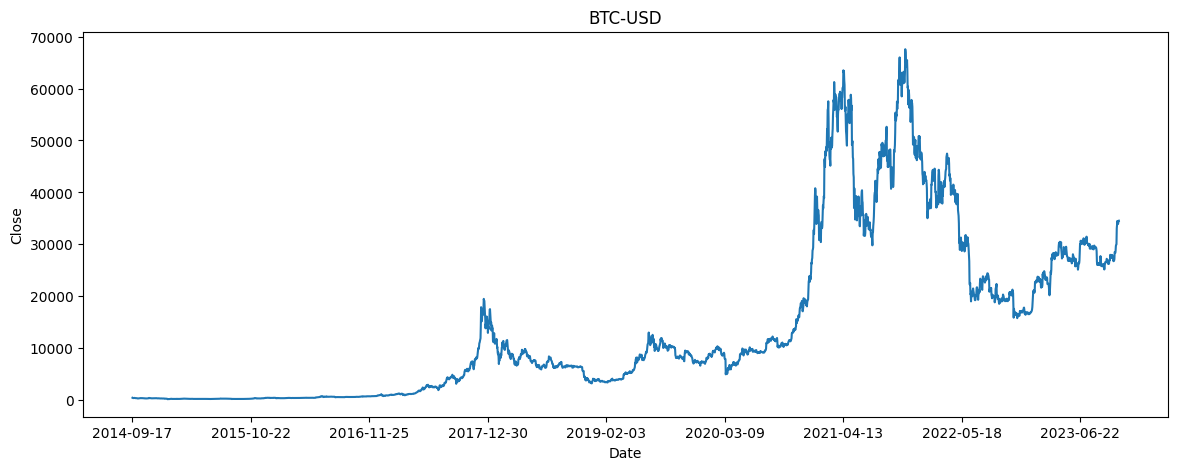

In [4]:
# Plotting the closing-price over time
plt.figure(figsize=(14,5))
plt.plot(df['Date'], df['Close'])
plt.xticks(np.arange(0, len(df['Date']), 400))
plt.title('BTC-USD')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

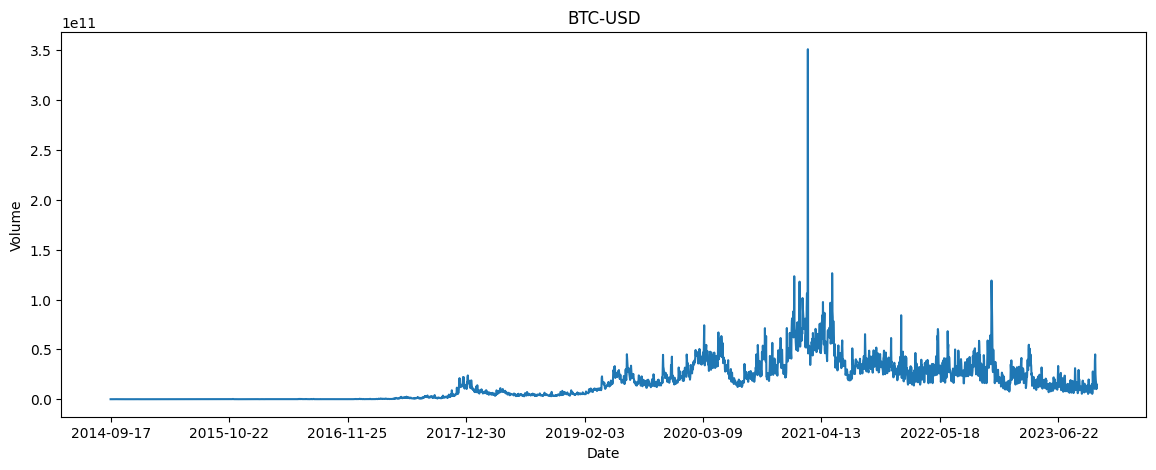

In [5]:
# Plotting the volume sold over time
plt.figure(figsize=(14,5))
plt.plot(df['Date'], df['Volume'])
plt.xticks(np.arange(0, len(df['Date']), 400))
plt.title('BTC-USD')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

# LSTM model

In [6]:
# Filtering so only datapoints from 01-06-2022 are included 
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
close_df = df[['Date','Close']]
close_df = close_df[close_df['Date'] > '2022-06-01']
del close_df['Date']
print(close_df)

             Close
2815  30467.488281
2816  29704.390625
2817  29832.914063
2818  29906.662109
2819  31370.671875
...            ...
3326  34156.648438
3327  33909.800781
3328  34089.574219
3329  34538.480469
3330  34554.171875

[516 rows x 1 columns]


In [7]:
# Normalization of data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

close_df['Close'] = scaler.fit_transform(np.array(close_df['Close']).reshape(-1,1))
close_df

Close
2815  0.782240
2816  0.741578
2817  0.748426
2818  0.752356
2819  0.830366
...        ...
3326  0.978818
3327  0.965664
3328  0.975244
3329  0.999164
3330  1.000000

[516 rows x 1 columns]

In [8]:
# Dividing into training- and test-sets
train_size = int(len(close_df)*0.7)
test_size = len(close_df) - train_size
train = close_df.iloc[0:train_size]
test = close_df.iloc[train_size:len(close_df)]
print(len(train), len(test))

361 155


In [9]:
# Function for making dataset/sequences
def make_dataset(dataset, look_back=1):
    data_X, data_Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        data_X.append(a)
        data_Y.append(dataset[i+look_back, 0])
    return np.array(data_X), np.array(data_Y)

In [10]:
# Creating the datasets
look_back = 15
train_X, train_Y = make_dataset(train.values, look_back)
test_X, test_Y = make_dataset(test.values, look_back)

print(train_X.shape, train_Y.shape)
print(test_X.shape, test_Y.shape)

# Reshaping input to be [samples, time steps, features] for the LSTM-model
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))
print(train_X.shape, test_X.shape)

(345, 15) (345,)
(139, 15) (139,)
(345, 15, 1) (139, 15, 1)


In [11]:
# Importing necessary libraries and creating the model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

model = Sequential()
model.add(LSTM(100, input_shape=(None, 1), activation='tanh'))
model.add(Dense(1))
#optimizer = tf.keras.optimizers.legacy.Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
history = model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=200, batch_size=32, verbose=1)
#history = model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=200, batch_size=64, verbose=1)


Epoch 1/200
11/11 [==============================] - 4s 86ms/step - loss: 0.0827 - val_loss: 0.0079
Epoch 2/200
11/11 [==============================] - 0s 20ms/step - loss: 0.0129 - val_loss: 0.0257
Epoch 3/200
11/11 [==============================] - 0s 22ms/step - loss: 0.0098 - val_loss: 0.0148
Epoch 4/200
11/11 [==============================] - 0s 22ms/step - loss: 0.0065 - val_loss: 0.0056
Epoch 5/200
11/11 [==============================] - 0s 21ms/step - loss: 0.0053 - val_loss: 0.0076
Epoch 6/200
11/11 [==============================] - 0s 22ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 7/200
11/11 [==============================] - 0s 22ms/step - loss: 0.0045 - val_loss: 0.0051
Epoch 8/200
11/11 [==============================] - 0s 22ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 9/200
11/11 [==============================] - 0s 20ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 10/200
11/11 [==============================] - 0s 21ms/step - loss: 0.0040 - val_loss: 0.0044

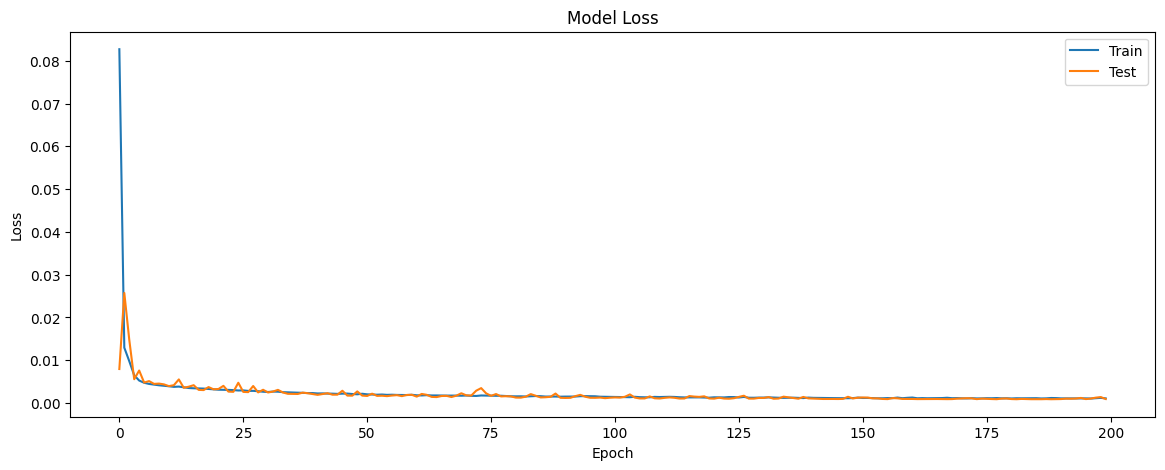

In [13]:
# Plotting the loss for the training- and test-set over the epochs
plt.figure(figsize=(14,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

In [14]:
# Making predictions
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# Inverting predictions
train_predict = scaler.inverse_transform(train_predict)
train_Y = scaler.inverse_transform([train_Y])
test_predict = scaler.inverse_transform(test_predict)
test_Y = scaler.inverse_transform([test_Y])

5/5 [==============================] - 0s 10ms/step


In [15]:
# Importing necessary libraries and calculating root mean squared error
import math
from sklearn.metrics import mean_squared_error

train_score = math.sqrt(mean_squared_error(train_Y[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(test_Y[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (test_score))


Train Score: 607.66 RMSE
Test Score: 573.29 RMSE


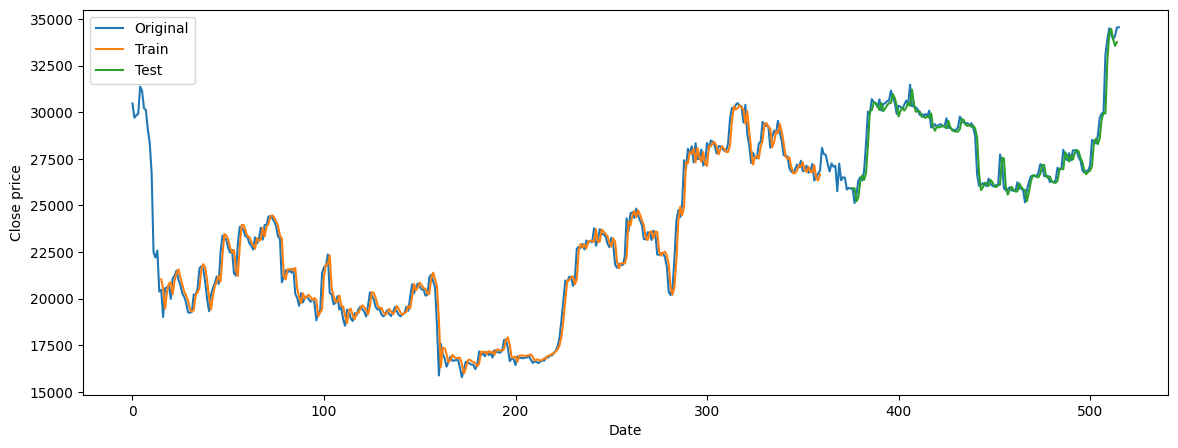

In [16]:
# Comparing original data with predictions and plotting in a graph with date as x-axis and close as y-axis
train_predict_plot = np.empty_like(close_df)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict
test_predict_plot = np.empty_like(close_df)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(close_df)-1, :] = test_predict
plt.figure(figsize=(14,5))
plt.xlabel('Date')
plt.ylabel('Close price')
plt.plot(scaler.inverse_transform(close_df))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.legend(['Original', 'Train', 'Test'])
plt.show()


15 day input [0.95763224 0.94683009 0.9305954  0.9149043  0.9001866  0.8863588
 0.87335908 0.8611393  0.84965968 0.83885819 0.82865477 0.81898654
 0.80979562 0.80104429 0.79269552]
15 day output [[0.7847146]]
16 day input [0.94683009 0.9305954  0.9149043  0.9001866  0.8863588  0.87335908
 0.8611393  0.84965968 0.83885819 0.82865477 0.81898654 0.80979562
 0.80104429 0.79269552 0.78471458]
16 day output [[0.77707577]]
17 day input [0.9305954  0.9149043  0.9001866  0.8863588  0.87335908 0.8611393
 0.84965968 0.83885819 0.82865477 0.81898654 0.80979562 0.80104429
 0.79269552 0.78471458 0.77707577]
17 day output [[0.7697544]]
18 day input [0.9149043  0.9001866  0.8863588  0.87335908 0.8611393  0.84965968
 0.83885819 0.82865477 0.81898654 0.80979562 0.80104429 0.79269552
 0.78471458 0.77707577 0.76975441]
18 day output [[0.76273066]]
19 day input [0.9001866  0.8863588  0.87335908 0.8611393  0.84965968 0.83885819
 0.82865477 0.81898654 0.80979562 0.80104429 0.79269552 0.78471458
 0.77707577 0

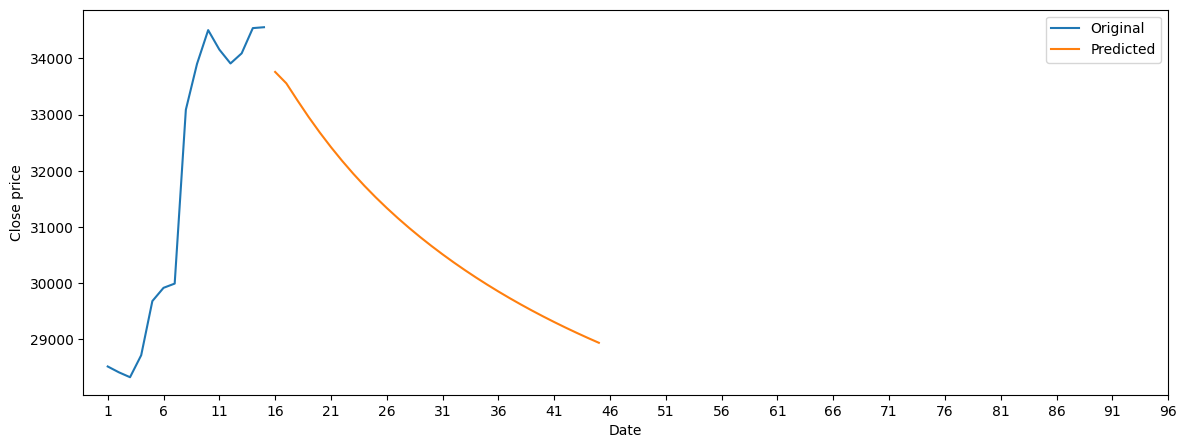

In [23]:
# Predicting the next 30 days 
x_input = test_X[-1]
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
lst_output = []
n_steps = 15
i = 0

while(i<30):
    if(len(temp_input)>15):
        x_input = np.array(temp_input[1:])
        print('{} day input {}'.format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print('{} day output {}'.format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        x_input = np.append(x_input, yhat[0])  
        x_input = x_input[1:]  
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i+1
print(lst_output)

day_new = np.arange(1, 16)
day_pred = np.arange(16, 46)

plt.figure(figsize=(14,5))
plt.plot(day_new, scaler.inverse_transform(close_df[len(close_df)-15:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))
plt.xticks(np.arange(1, 100, 5))
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(['Original', 'Predicted'])
plt.show()